# Doc Scanner

In [1]:
import src.scan as scan

### Escaner


In [2]:
scanner = scan.DocScanner()

In [3]:
scanner.scan("./partitura.jpg")

Proccessed partitura.jpg


# Sheet Scaner

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

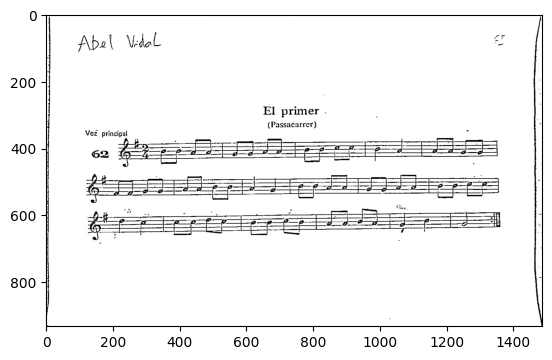

In [5]:
img = cv2.imread("./scaned/partitura.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

127.0


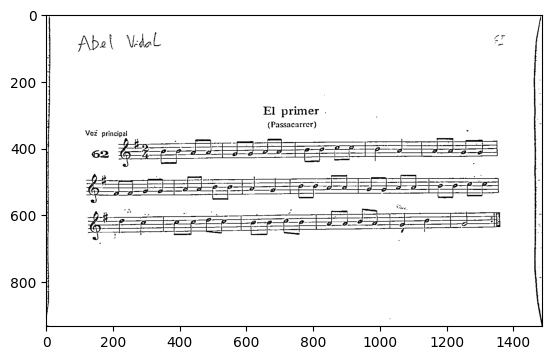

In [6]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img_bw = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)
plt.imshow(img_bw, cmap="gray")
print(ret)

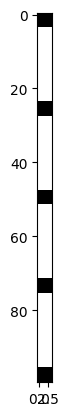

In [7]:
template = cv2.cvtColor(cv2.imread("./png/staff_min.png"), cv2.COLOR_BGR2GRAY)
plt.imshow(template, cmap="gray")

(933, 1487)
(100, 4)
[252.    10.08] [706.    28.24]
[138.5    5.54] [365.5   14.62]
[81.75  3.27] [195.25   7.81]
[53.375  2.135] [110.125   4.405]
[39.1875  1.5675] [67.5625  2.7025]
[32.09375  1.28375] [46.28125  1.85125]
[42.734375  1.709375] [49.828125  1.993125]
[40.9609375  1.6384375] [44.5078125  1.7803125]
[43.62109375  1.74484375] [45.39453125  1.81578125]
[44.95117187  1.79804687] [45.83789062  1.83351562]
[45.61621094  1.82464844] [46.05957031  1.84238281]
[45.94873047  1.83794922] [46.17041016  1.84681641]
[46.11499023  1.84459961] [46.22583008  1.8490332 ]
(46, 2)


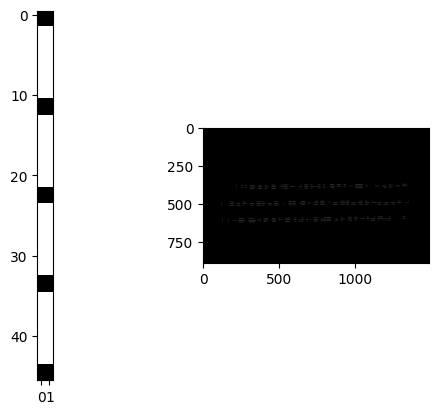

In [8]:
def get_mean(img, temp, shape):
    t = cv2.resize(temp, shape[::-1].astype(int), interpolation = cv2.INTER_CUBIC)
    return np.amax(cv2.matchTemplate(img, t, cv2.TM_CCOEFF_NORMED))


print(img_bw.shape)
print(template.shape)
limits = (0.25, img_bw.shape[0]/template.shape[0])
ratio = (sum(limits)/2)
last_ratio = (limits[0], ratio, limits[1])
shape = np.array(template.shape) * ratio
last_res = get_mean(img_bw, template, shape)
new_shape1, new_shape2 = np.zeros(2), np.ones(2)
while not all(new_shape1.astype(int) == new_shape2.astype(int)):
    new_shape1 = np.array(template.shape) * ((last_ratio[0]+last_ratio[1])/2)
    new_shape2 = np.array(template.shape) * ((last_ratio[2]+last_ratio[1])/2)
    print(new_shape1, new_shape2)
    res1 = get_mean(img_bw, template, new_shape1)
    res2 = get_mean(img_bw, template, new_shape2)
    if res1 > res2:
        new_ratio = ((last_ratio[0]+last_ratio[1])/2)
        last_ratio = (last_ratio[0], new_ratio, last_ratio[1])
    elif res2 > res1:
        new_ratio = ((last_ratio[2]+last_ratio[1])/2)
        last_ratio = (last_ratio[1], new_ratio, last_ratio[2])
    else:
        break
shape = np.rint(np.array(template.shape) * new_ratio)
ratio = new_ratio
temp = cv2.resize(template, shape[::-1].astype(int), interpolation = cv2.INTER_CUBIC)
print(temp.shape)
plt.subplot(121)
plt.imshow(temp, cmap="gray")
result = cv2.matchTemplate(img_bw, temp, cv2.TM_CCOEFF_NORMED)
result = np.where(result > 0.75, 1, 0)
plt.subplot(122)
plt.imshow(result, cmap="gray")

In [9]:
import math

class Rectangle(object):
    def __init__(self, x, y, w, h):
        self.x = x;
        self.y = y;
        self.w = w;
        self.h = h;
        self.middle = self.x + self.w/2, self.y + self.h/2
        self.area = self.w * self.h

    def overlap(self, other):
        overlap_x = max(0, min(self.x + self.w, other.x + other.w) - max(self.x, other.x));
        overlap_y = max(0, min(self.y + self.h, other.y + other.h) - max(self.y, other.y));
        overlap_area = overlap_x * overlap_y
        return overlap_area / self.area

    def distance(self, other):
        dx = self.middle[0] - other.middle[0]
        dy = self.middle[1] - other.middle[1]
        return math.sqrt(dx*dx + dy*dy)

    def merge(self, other):
        x = min(self.x, other.x)
        y = min(self.y, other.y)
        w = max(self.x + self.w, other.x + other.w) - x
        h = max(self.y + self.h, other.y + other.h) - y
        return Rectangle(x, y, w, h)

    def draw(self, img, color, thickness):
        pos = ((int)(self.x), (int)(self.y))
        size = ((int)(self.x + self.w), (int)(self.y + self.h))
        cv2.rectangle(img, pos, size, color, thickness)
    
    def __str__(self) -> str:
        return f"Rectangle(x:{self.x}, y:{self.y}, w:{self.w}, h:{self.h})"

In [10]:
rects = np.array([Rectangle(pt[1], pt[0], temp.shape[1], temp.shape[0]) for pt in np.array(np.where(result == 1)).T])
print(rects)

 <__main__.Rectangle object at 0x00000206BC42B250> ...


In [11]:
def merge_recs(recs, threshold):
    filtered_recs = []
    while len(recs) > 0:
        r = recs.pop(0)
        recs.sort(key=lambda rec: rec.distance(r))
        merged = True
        while(merged):
            merged = False
            i = 0
            for _ in range(len(recs)):
                if r.overlap(recs[i]) > threshold or recs[i].overlap(r) > threshold:
                    r = r.merge(recs.pop(i))
                    merged = True
                elif recs[i].distance(r) > r.w/2 + recs[i].w/2:
                    break
                else:
                    i += 1
        filtered_recs.append(r)
    return filtered_recs

In [12]:
def show_recs(bg, recs, color = (0, 0, 255)):
    recs_img = bg.copy()
    for r in recs:
        r.draw(recs_img, color, 2)
    plt.imshow(recs_img)

Filtering weak staff matches...
Merging staff image results...


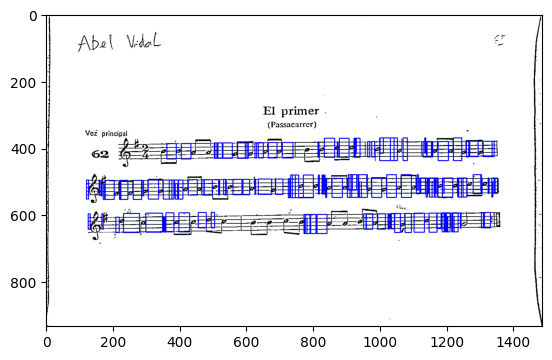

In [13]:
print("Filtering weak staff matches...")
heights = [r.y for r in rects] + [0]
histo = [heights.count(i) for i in range(0, max(heights) + 1)]
avg = np.mean(list(set(histo)))
staff_recs = [r for r in rects if histo[r.y] > avg]

print("Merging staff image results...")
staff_recs = merge_recs(staff_recs, 0.01)
show_recs(img, staff_recs)

Discovering staff locations...


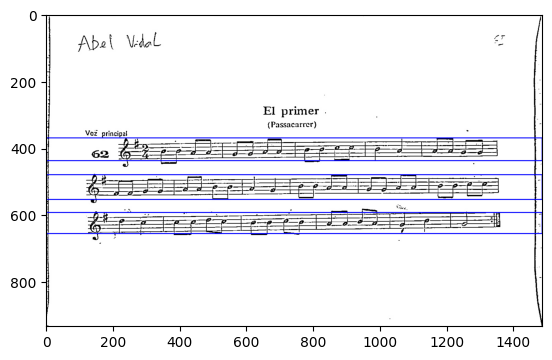

In [14]:
print("Discovering staff locations...")
staff_boxes = merge_recs([Rectangle(0, r.y, img.shape[1], r.h) for r in staff_recs], 0.01)
show_recs(img, staff_boxes)

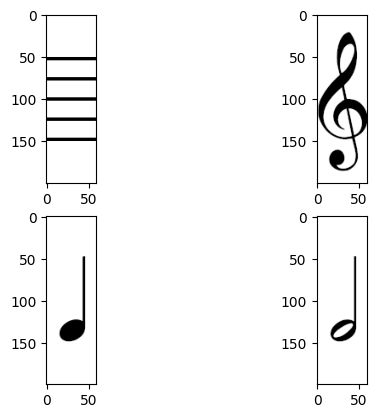

In [15]:
staff_img = cv2.cvtColor(cv2.imread("./png/staff.png"), cv2.COLOR_BGR2GRAY)
Gclef_img = cv2.cvtColor(cv2.imread("./png/Gclef.png"), cv2.COLOR_BGR2GRAY)
negra_img = cv2.cvtColor(cv2.imread("./png/negra.png"), cv2.COLOR_BGR2GRAY)
blanca_img = cv2.cvtColor(cv2.imread("./png/blanca.png"), cv2.COLOR_BGR2GRAY)

plt.subplot(221)
plt.imshow(staff_img, cmap="gray")
plt.subplot(222)
plt.imshow(Gclef_img, cmap="gray")
plt.subplot(223)
plt.imshow(negra_img, cmap="gray")
plt.subplot(224)
plt.imshow(blanca_img, cmap="gray")

In [23]:
def cut_staff(img, boxes, margin = 0):
    margin = int(margin)
    return [img[box.y-margin:box.y+box.h+margin,box.x:box.x+box.w] for box in boxes]

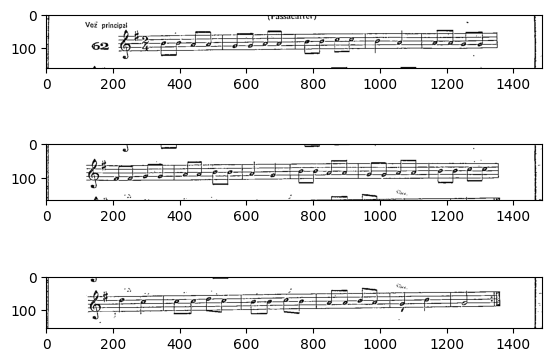

In [24]:
staff = cut_staff(img_bw, staff_boxes, 100*ratio)

plt.subplot(311)
plt.imshow(staff[0], cmap="gray")
plt.subplot(312)
plt.imshow(staff[1], cmap="gray")
plt.subplot(313)
plt.imshow(staff[2], cmap="gray")

In [51]:
def locate_img(img, template, scale, threshold):
    shape = np.rint(np.array(template.shape) * scale)
    temp = cv2.resize(template, shape[::-1].astype(int), interpolation = cv2.INTER_CUBIC)
    result = cv2.matchTemplate(img_bw, temp, cv2.TM_CCOEFF_NORMED)
    print(np.max(result))
    result = np.where(result > threshold, 1, 0)
    rects = np.array([Rectangle(pt[1], pt[0], temp.shape[1], temp.shape[0]) for pt in np.array(np.where(result == 1)).T])
    plt.imshow(result, cmap="gray")
    return list(rects)

0.44875115


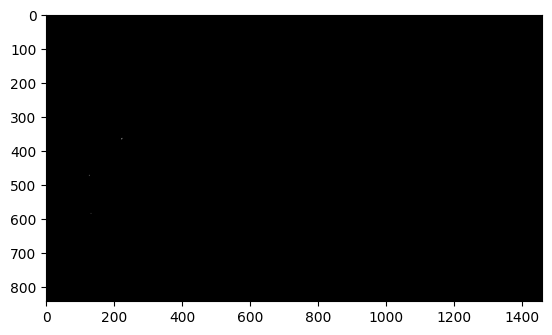

In [54]:
Gclef_recs = locate_img(img_bw, Gclef_img, ratio, 0.4)

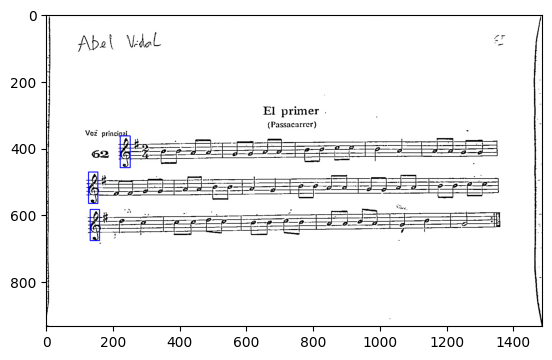

In [55]:
Gclef_recs = merge_recs(Gclef_recs, 0.01)
show_recs(img, Gclef_recs)

0.52159446


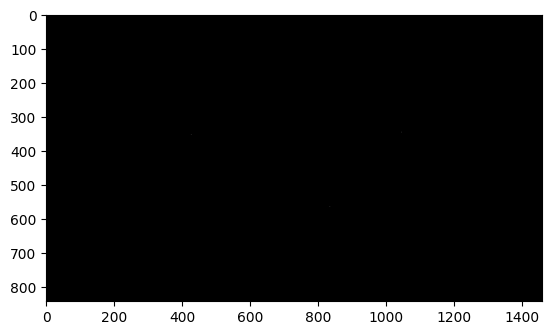

In [56]:
blacna_recs = locate_img(img_bw, blanca_img, ratio, 0.50)

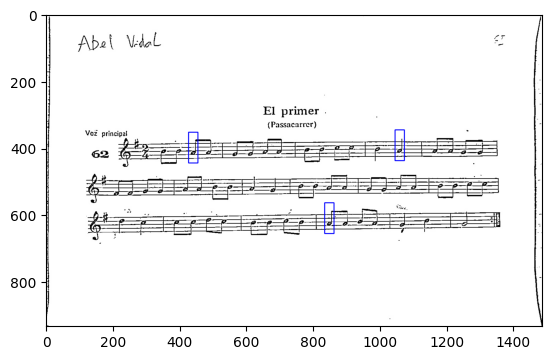

In [57]:
blacna_recs = merge_recs(blacna_recs, 0.01)
show_recs(img, blacna_recs)

0.53564507


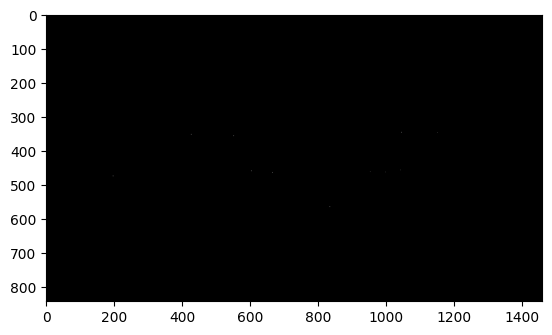

In [58]:
negra_recs = locate_img(img_bw, negra_img, ratio, 0.50)

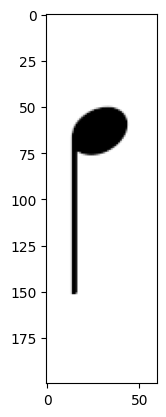

In [66]:
plt.imshow(negra_img[::-1,::-1], cmap="gray")

0.53564507


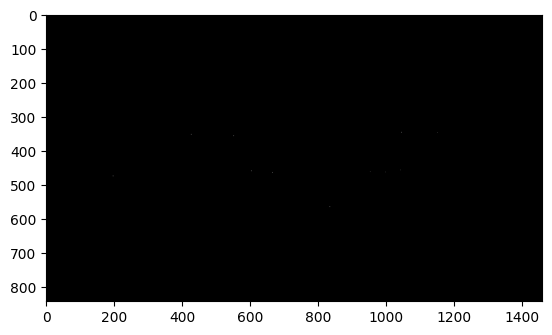

In [67]:
negra_recs = locate_img(img_bw, negra_img, ratio, 0.50)

0.5259028


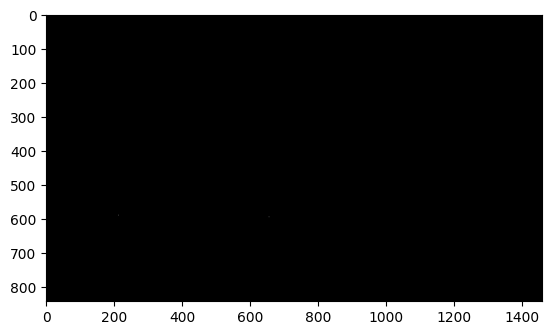

In [68]:
negra_recs += locate_img(img_bw, negra_img[::-1,::-1], ratio, 0.50)

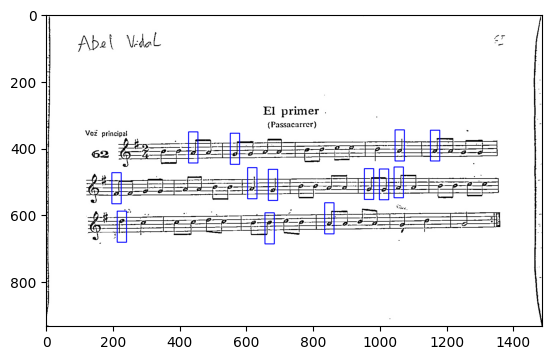

In [69]:
negra_recs = merge_recs(negra_recs, 0.01)
show_recs(img, negra_recs)